<center> <h1>mIA-X 8ª Edición</h1> </center>

<center> <h1>Práctica 9 - Modelos Generativos</h1> </center>

<center> <h1>Javier Langeber Gavilán</h1> </center>

<center> <h1>Ejercicio 5</h1> </center>

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as tf
from keras.datasets import fashion_mnist

In [2]:
from keras.models import Model, load_model # for assembling a Neural Network model
from keras.layers import Input, Dense, Embedding, Reshape, Concatenate, Flatten, Dropout # for adding layers
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, ReLU, LeakyReLU # for adding layers
from keras.utils import plot_model # for plotting model diagram
from keras.optimizers import Adam # for model optimization 

In [39]:
(x_train_or, y_train), (x_test_or, y_test) = fashion_mnist.load_data()

In [40]:
plt.set_cmap("gray")

<Figure size 640x480 with 0 Axes>

9
9


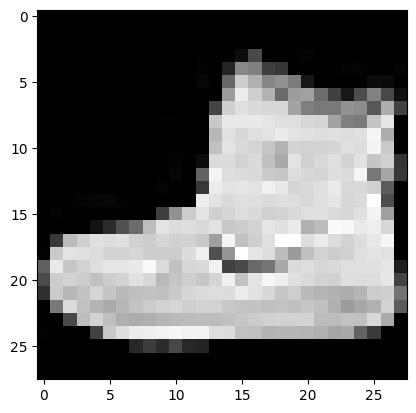

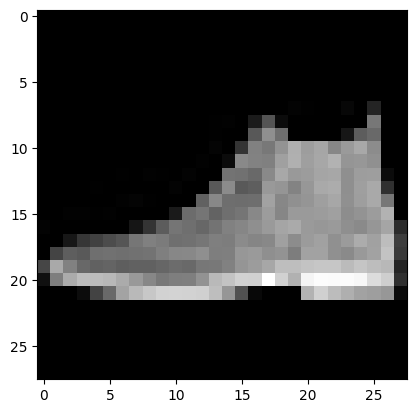

In [41]:
plt.imshow(x_train_or[0])
print(y_train[0])
plt.figure()
plt.imshow(x_test_or[0])
print(y_test[0])

In [42]:
len(pd.Series(y_test).value_counts())

10

In [43]:
x_train = ((x_train_or / 255) - 0.5) * 2
x_test = ((x_test_or / 255) - 0.5) * 2

In [44]:
x_train[0].max().max()

1.0

In [45]:
x_train[0].min().min()

-1.0

In [46]:
def generator(latent_dim, in_shape=(7,7,1), n_cats=10):
        
    # Label Inputs
    in_label = Input(shape=(1,), name='Generator-Label-Input-Layer') # Input Layer
    lbls = Embedding(n_cats, 50, name='Generator-Label-Embedding-Layer')(in_label) # Embed label to vector
    
    # Scale up to image dimensions
    n_nodes = in_shape[0] * in_shape[1] 
    lbls = Dense(n_nodes, name='Generator-Label-Dense-Layer')(lbls)
    lbls = Reshape((in_shape[0], in_shape[1], 1), name='Generator-Label-Reshape-Layer')(lbls) # New shape

    # Generator Inputs (latent vector)
    in_latent = Input(shape=latent_dim, name='Generator-Latent-Input-Layer')
    
    # Image Foundation 
    n_nodes = 7 * 7 * 128 # number of nodes in the initial layer
    g = Dense(n_nodes, name='Generator-Foundation-Layer')(in_latent)
    g = ReLU(name='Generator-Foundation-Layer-Activation-1')(g)
    g = Reshape((in_shape[0], in_shape[1], 128), name='Generator-Foundation-Layer-Reshape-1')(g)
    
    # Combine both inputs so it has two channels
    concat = Concatenate(name='Generator-Combine-Layer')([g, lbls])

    # Hidden Layer 1
    g = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-1')(concat)
    g = ReLU(name='Generator-Hidden-Layer-Activation-1')(g)
    
    # Hidden Layer 2
    g = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-2')(g)
    g = ReLU(name='Generator-Hidden-Layer-Activation-2')(g)
    
    # Output Layer (Note, we use only one filter because we have a greysclae image. Color image would have three
    output_layer = Conv2D(filters=1, kernel_size=(7,7), activation='tanh', padding='same', name='Generator-Output-Layer')(g)
    
    # Define model
    model = Model([in_latent, in_label], output_layer, name='Generator')
    return model

# Instantiate
latent_dim=100 # Our latent space has 100 dimensions. We can change it to any number
gen_model = generator(latent_dim)

# Show model summary and plot model diagram
gen_model.summary()



Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Generator-Latent-Input-Layer (  [(None, 100)]       0           []                               
 InputLayer)                                                                                      
                                                                                                  
 Generator-Label-Input-Layer (I  [(None, 1)]         0           []                               
 nputLayer)                                                                                       
                                                                                                  
 Generator-Foundation-Layer (De  (None, 6272)        633472      ['Generator-Latent-Input-Layer[0]
 nse)                                                            [0]']                    

In [47]:
def discriminator(in_shape=(28,28,1), n_cats=10):
    
    # Label Inputs
    in_label = Input(shape=(1,), name='Discriminator-Label-Input-Layer') # Input Layer
    lbls = Embedding(n_cats, 50, name='Discriminator-Label-Embedding-Layer')(in_label) # Embed label to vector
    
    # Scale up to image dimensions
    n_nodes = in_shape[0] * in_shape[1] 
    lbls = Dense(n_nodes, name='Discriminator-Label-Dense-Layer')(lbls)
    lbls = Reshape((in_shape[0], in_shape[1], 1), name='Discriminator-Label-Reshape-Layer')(lbls) # New shape

    # Image Inputs
    in_image = Input(shape=in_shape, name='Discriminator-Image-Input-Layer')
    
    # Combine both inputs so it has two channels
    concat = Concatenate(name='Discriminator-Combine-Layer')([in_image, lbls])

    # Hidden Layer 1
    h = Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', name='Discriminator-Hidden-Layer-1')(concat)
    h = LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-1')(h)
    
    # Hidden Layer 2
    h = Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', name='Discriminator-Hidden-Layer-2')(h)
    h = LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-2')(h)
    h = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid', name='Discriminator-MaxPool-Layer-2')(h) # Max Pool
    
    # Flatten and Output Layers
    h = Flatten(name='Discriminator-Flatten-Layer')(h) # Flatten the shape
    h = Dropout(0.2, name='Discriminator-Flatten-Layer-Dropout')(h) # Randomly drop some connections for better generalization
   
    output_layer = Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')(h) # Output Layer
    
    # Define model
    model = Model([in_image, in_label], output_layer, name='Discriminator')
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model

# Instantiate
dis_model = discriminator()

# Show model summary and plot model diagram
dis_model.summary()
# plot_model(dis_model, show_shapes=True, show_layer_names=True, dpi=400, to_file=main_dir+'/pics/discriminator_structure.png')


Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Discriminator-Label-Input-Laye  [(None, 1)]         0           []                               
 r (InputLayer)                                                                                   
                                                                                                  
 Discriminator-Label-Embedding-  (None, 1, 50)       500         ['Discriminator-Label-Input-Layer
 Layer (Embedding)                                               [0][0]']                         
                                                                                                  
 Discriminator-Label-Dense-Laye  (None, 1, 784)      39984       ['Discriminator-Label-Embedding-L
 r (Dense)                                                       ayer[0][0]']         

In [48]:
def def_gan(generator, discriminator):
    
    # We don't want to train the weights of discriminator at this stage. Hence, make it not trainable
    discriminator.trainable = False
    
    # Get Generator inputs / outputs
    gen_latent, gen_label = generator.input # Latent and label inputs from the generator
    gen_output = generator.output # Generator output image
    
    # Connect image and label from the generator to use as input into the discriminator
    gan_output = discriminator([gen_output, gen_label])
    
    # Define GAN model
    model = Model([gen_latent, gen_label], gan_output, name="cDCGAN")
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

# Instantiate
gan_model = def_gan(gen_model, dis_model)

# Show model summary and plot model diagram
gan_model.summary()
# plot_model(gan_model, show_shapes=True, show_layer_names=True, dpi=400, to_file=main_dir+'/pics/dcgan_structure.png')


Model: "cDCGAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Generator-Latent-Input-Layer (  [(None, 100)]       0           []                               
 InputLayer)                                                                                      
                                                                                                  
 Generator-Label-Input-Layer (I  [(None, 1)]         0           []                               
 nputLayer)                                                                                       
                                                                                                  
 Generator-Foundation-Layer (De  (None, 6272)        633472      ['Generator-Latent-Input-Layer[0]
 nse)                                                            [0]']                       

In [49]:

def real_samples(dataset, categories, n):
    
    # Create a random list of indices
    indx = np.random.randint(0, dataset.shape[0], n)
    
    # Select real data samples (images and category labels) using the list of random indeces from above
    X, cat_labels = dataset[indx], categories[indx]

    # Class labels
    y = np.ones((n, 1))
    return [X, cat_labels], y
    
    
def latent_vector(latent_dim, n, n_cats=10):
    
    # Generate points in the latent space
    latent_input = np.random.randn(latent_dim * n)
    
    # Reshape into a batch of inputs for the network
    latent_input = latent_input.reshape(n, latent_dim)
    
    # Generate category labels 
    cat_labels = np.random.randint(0, n_cats, n)
    return [latent_input, cat_labels] 
  
  
def fake_samples(generator, latent_dim, n):
    
    # Draw latent variables
    latent_output, cat_labels = latent_vector(latent_dim, n)
    
    # Predict outputs (i.e., generate fake samples)
    X = generator.predict([latent_output, cat_labels])
    
    # Create class labels
    y = np.zeros((n, 1))
    return [X, cat_labels], y

In [50]:

def show_fakes(generator, latent_dim, n=10):
    
    # Get fake (generated) samples
    x_fake, y_fake = fake_samples(generator, latent_dim, n)
    
    # Rescale from [-1, 1] to [0, 1]
    X_tst = (x_fake[0] + 1) / 2.0
    
    # Display fake (generated) images
    fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
    k=0
    for i in range(0,2):
        for j in range(0,5):
            axs[i,j].matshow(X_tst[k], cmap='gray')
            axs[i,j].set(title=x_fake[1][k])
            axs[i,j].axis('off')
            k=k+1
    plt.show() 

In [51]:
def train(g_model, d_model, gan_model, dataset, categories, latent_dim, n_epochs=10, n_batch=128, n_eval=200):
    # Number of batches to use per each epoch
    batch_per_epoch = int(dataset.shape[0] / n_batch)
    print(' batch_per_epoch: ',  batch_per_epoch)
    # Our batch to train the discriminator will consist of half real images and half fake (generated) images
    half_batch = int(n_batch / 2)
    
    # We will manually enumare epochs 
    for i in range(n_epochs):
        
        # Enumerate batches over the training set
        for j in range(batch_per_epoch):
    
        # Discriminator training
            # Prep real samples
            [x_real, cat_labels_real], y_real = real_samples(dataset, categories, half_batch)
            # Train discriminator with real samples
            discriminator_loss1, _ = d_model.train_on_batch([x_real, cat_labels_real], y_real)
            
            # Prep fake (generated) samples
            [x_fake, cat_labels_fake], y_fake = fake_samples(g_model, latent_dim, half_batch)
            # Train discriminator with fake samples
            discriminator_loss2, _ = d_model.train_on_batch([x_fake, cat_labels_fake], y_fake)


        # Generator training
            # Get values from the latent space to be used as inputs for the generator
            [latent_input, cat_labels] = latent_vector(latent_dim, n_batch)
            # While we are generating fake samples, 
            # we want GAN generator model to create examples that resemble the real ones,
            # hence we want to pass labels corresponding to real samples, i.e. y=1, not 0.
            y_gan = np.ones((n_batch, 1))

            # Train the generator via a composite GAN model
            generator_loss = gan_model.train_on_batch([latent_input, cat_labels], y_gan)
        
        # Summarize training progress and loss
            if (j) % n_eval == 0:
                print('Epoch: %d, Batch: %d/%d, D_Loss_Real=%.3f, D_Loss_Fake=%.3f Gen_Loss=%.3f' % 
                      (i+1, j+1, batch_per_epoch, discriminator_loss1, discriminator_loss2, generator_loss))
                show_fakes(g_model, latent_dim)

In [52]:
data=x_train.copy()
data=data.reshape(x_train.shape[0], 28, 28, 1)
# data = (data - 127.5) / 127.5  # Normalize the images to [-1, 1]
print("Shape of the scaled array: ", data.shape)

Shape of the scaled array:  (60000, 28, 28, 1)


 batch_per_epoch:  468
2/2 [==============================] - 0s 39ms/step
Epoch: 1, Batch: 1/468, D_Loss_Real=0.579, D_Loss_Fake=0.699 Gen_Loss=0.689
1/1 [==============================] - 0s 112ms/step


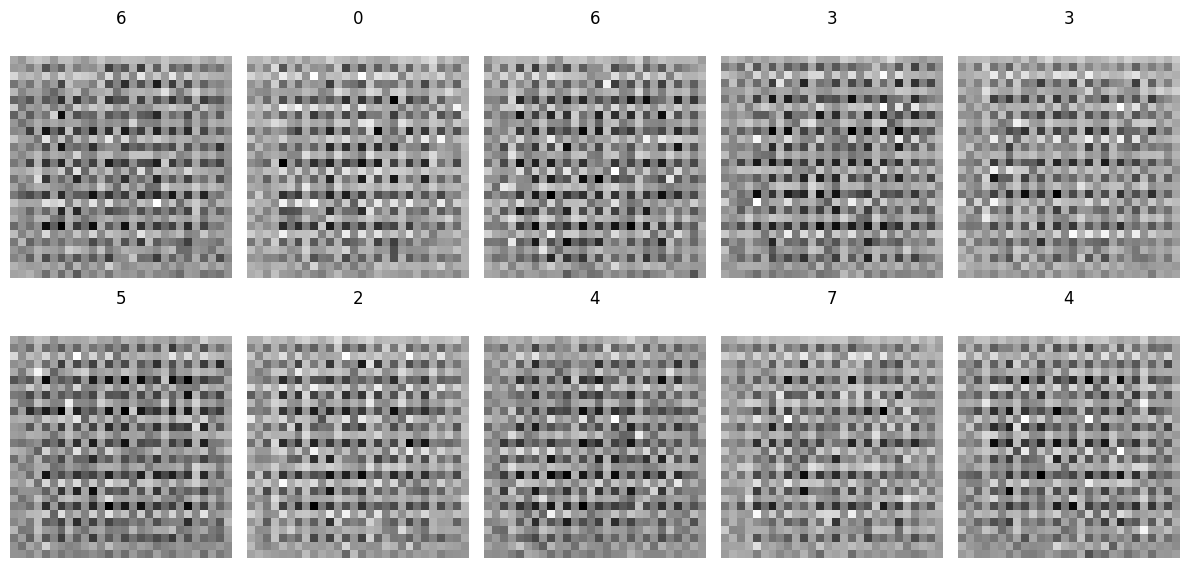

2/2 [==============================] - 0s 4ms/step
Epoch: 1, Batch: 201/468, D_Loss_Real=0.645, D_Loss_Fake=0.561 Gen_Loss=0.952
1/1 [==============================] - 0s 18ms/step


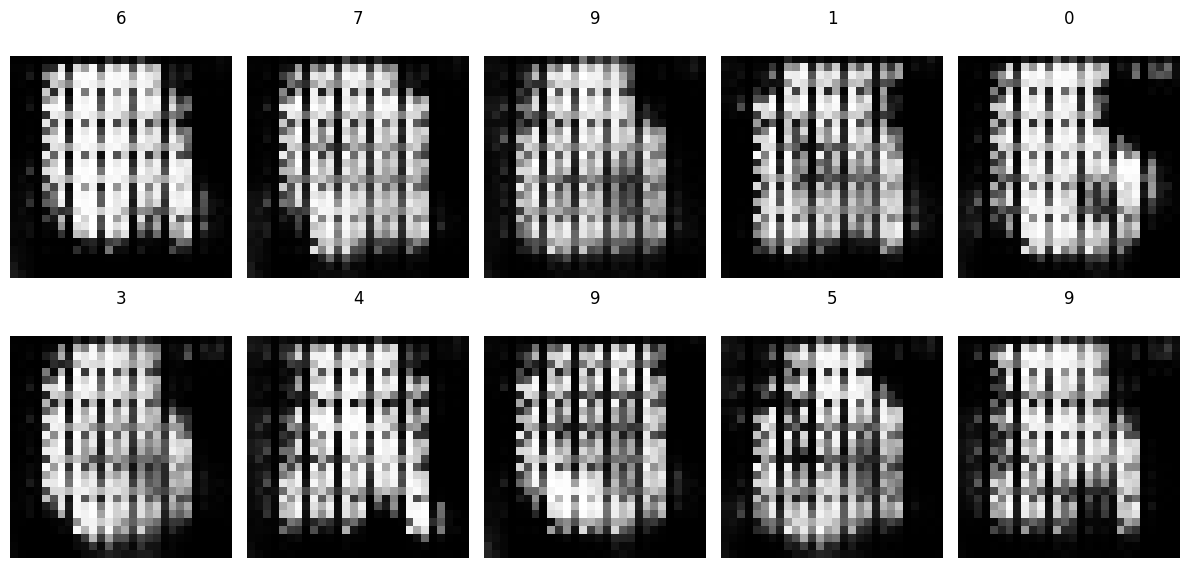

2/2 [==============================] - 0s 4ms/step
Epoch: 1, Batch: 401/468, D_Loss_Real=0.571, D_Loss_Fake=0.634 Gen_Loss=0.847
1/1 [==============================] - 0s 18ms/step


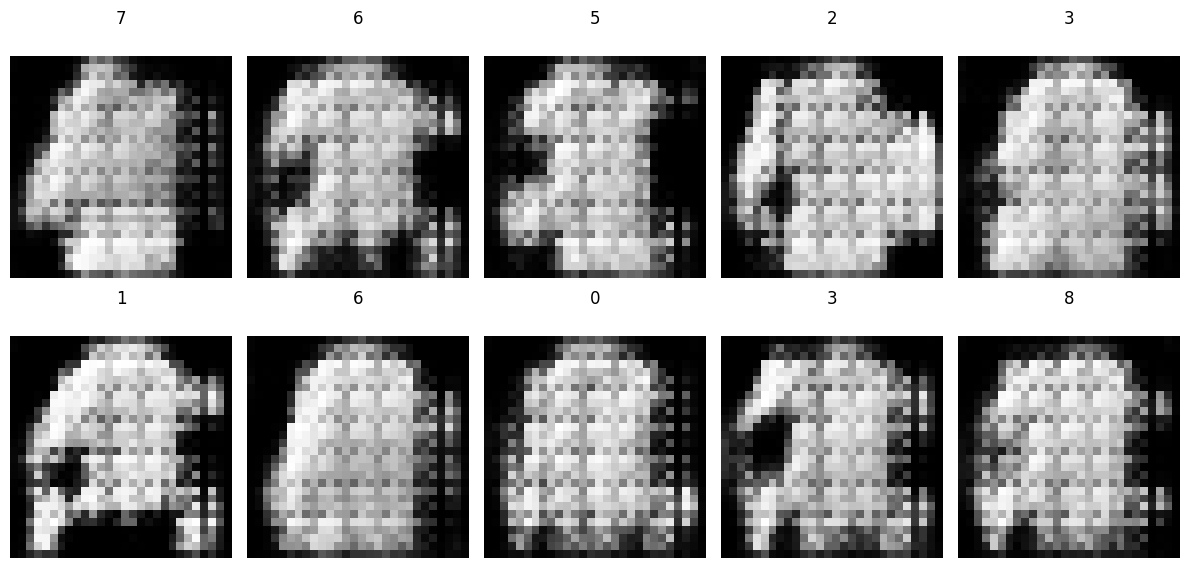

2/2 [==============================] - 0s 4ms/step
Epoch: 2, Batch: 1/468, D_Loss_Real=0.628, D_Loss_Fake=0.588 Gen_Loss=0.884
1/1 [==============================] - 0s 18ms/step


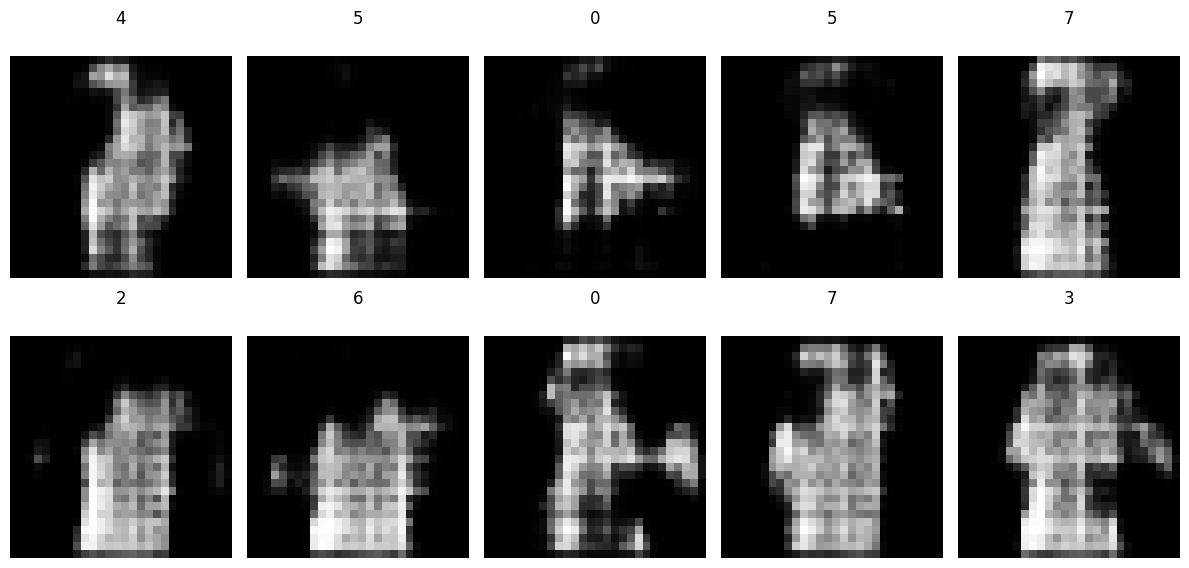

2/2 [==============================] - 0s 3ms/step
Epoch: 2, Batch: 201/468, D_Loss_Real=0.598, D_Loss_Fake=0.523 Gen_Loss=0.984
1/1 [==============================] - 0s 18ms/step


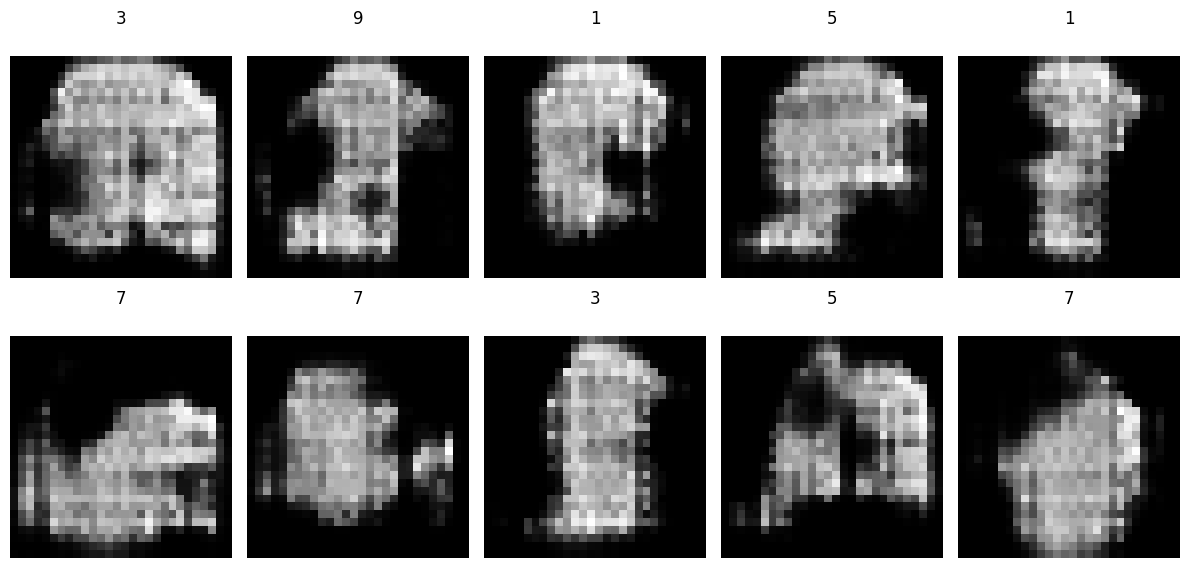

2/2 [==============================] - 0s 5ms/step
Epoch: 2, Batch: 401/468, D_Loss_Real=0.631, D_Loss_Fake=0.679 Gen_Loss=0.801
1/1 [==============================] - 0s 20ms/step


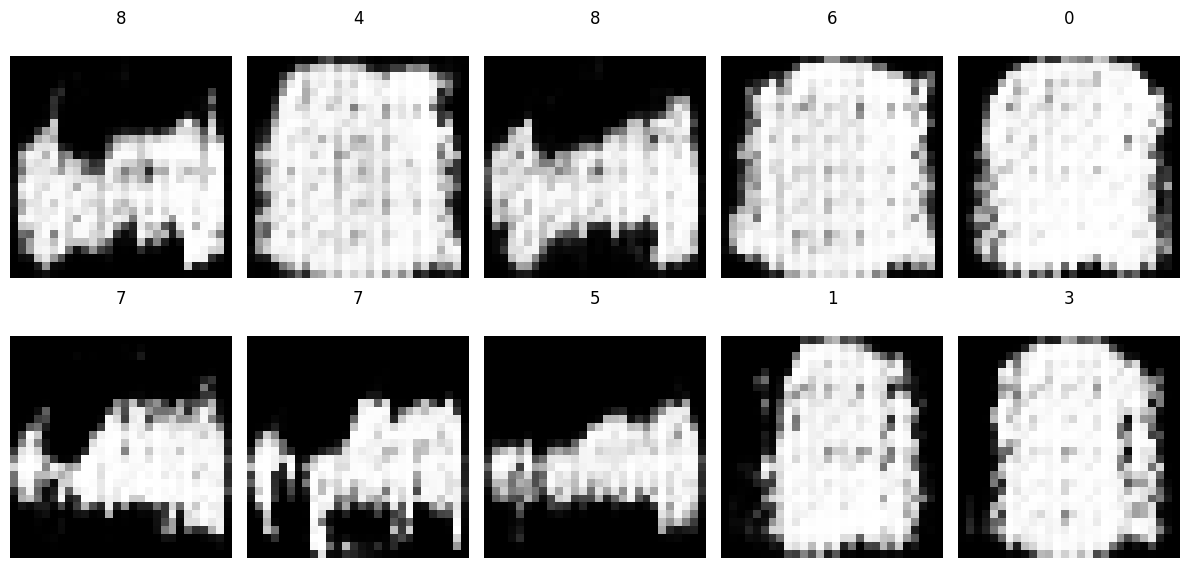

2/2 [==============================] - 0s 4ms/step
Epoch: 3, Batch: 1/468, D_Loss_Real=0.662, D_Loss_Fake=0.657 Gen_Loss=0.785
1/1 [==============================] - 0s 20ms/step


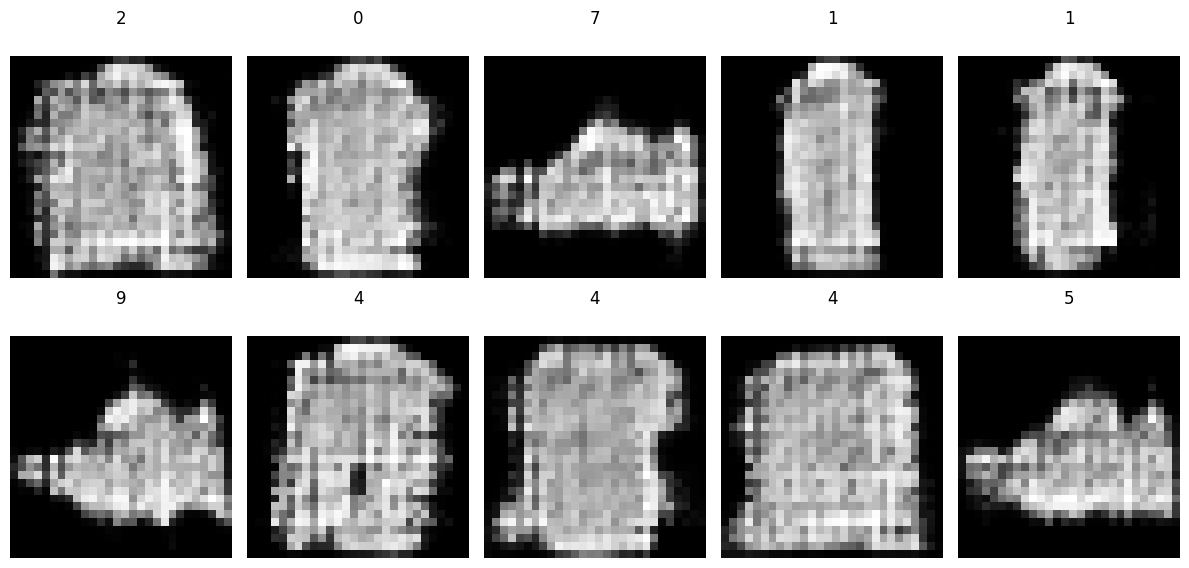

2/2 [==============================] - 0s 5ms/step
Epoch: 3, Batch: 201/468, D_Loss_Real=0.681, D_Loss_Fake=0.703 Gen_Loss=0.810
1/1 [==============================] - 0s 22ms/step


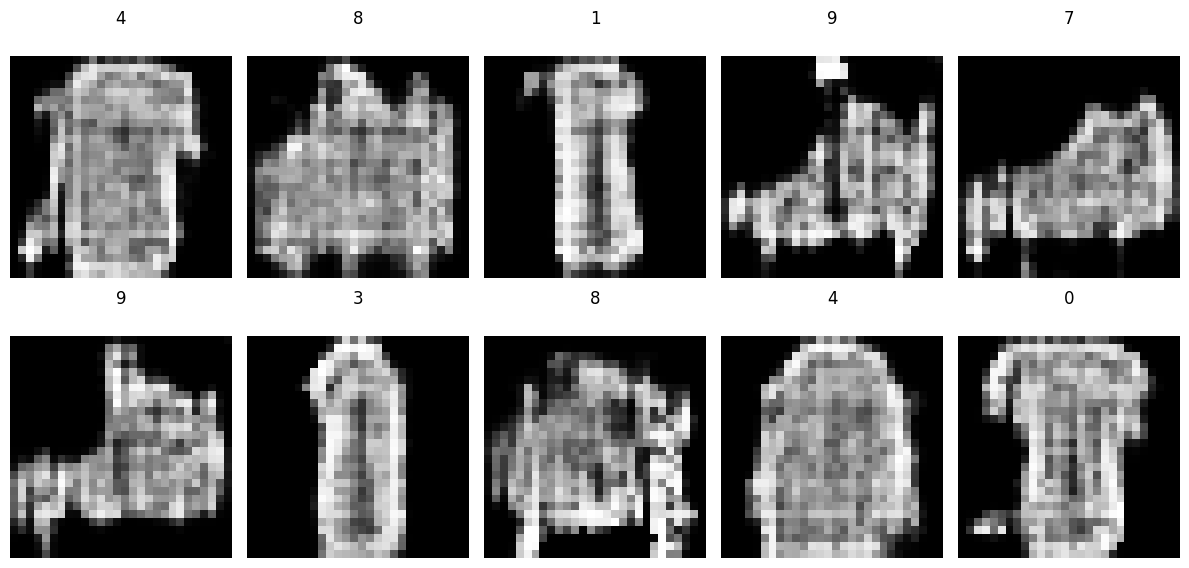

2/2 [==============================] - 0s 4ms/step
Epoch: 3, Batch: 401/468, D_Loss_Real=0.675, D_Loss_Fake=0.703 Gen_Loss=0.770
1/1 [==============================] - 0s 18ms/step


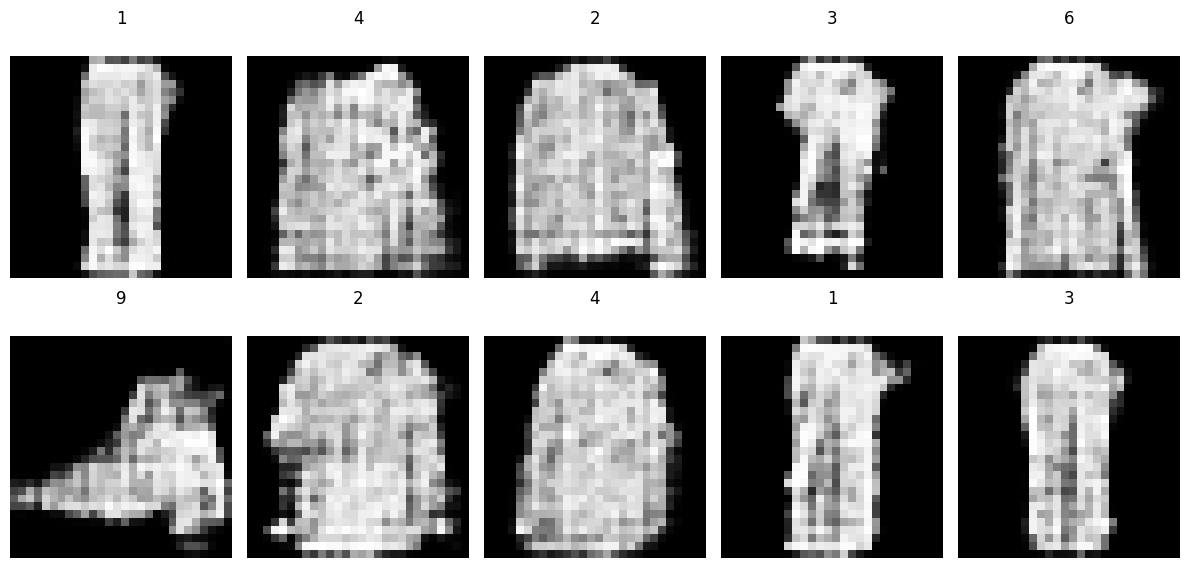

2/2 [==============================] - 0s 4ms/step
Epoch: 4, Batch: 1/468, D_Loss_Real=0.668, D_Loss_Fake=0.591 Gen_Loss=0.911
1/1 [==============================] - 0s 25ms/step


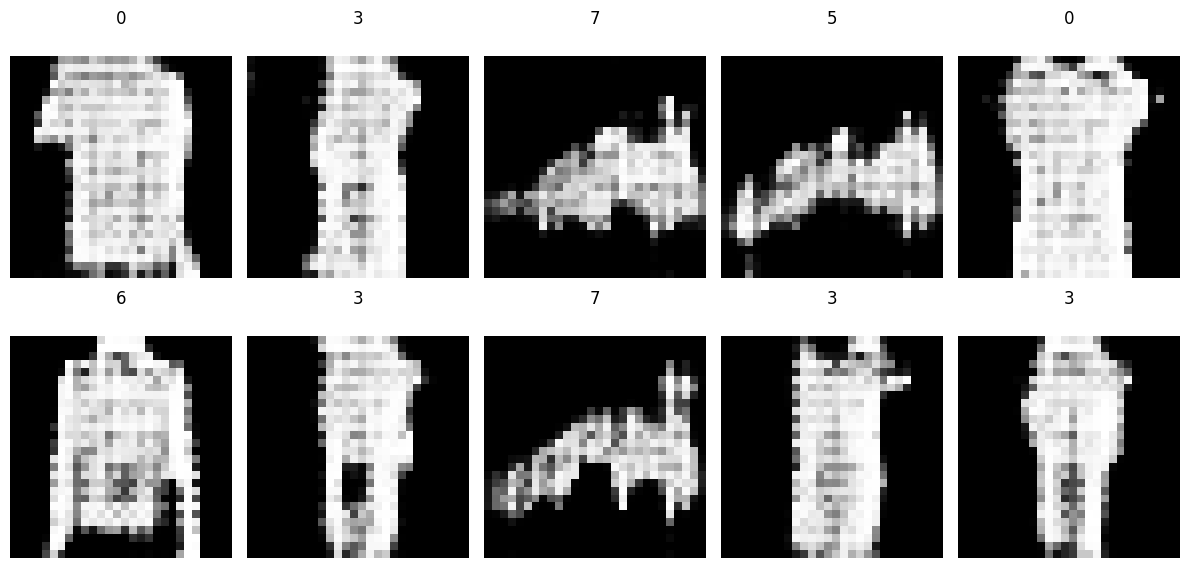

2/2 [==============================] - 0s 4ms/step
Epoch: 4, Batch: 201/468, D_Loss_Real=0.693, D_Loss_Fake=0.631 Gen_Loss=0.797
1/1 [==============================] - 0s 20ms/step


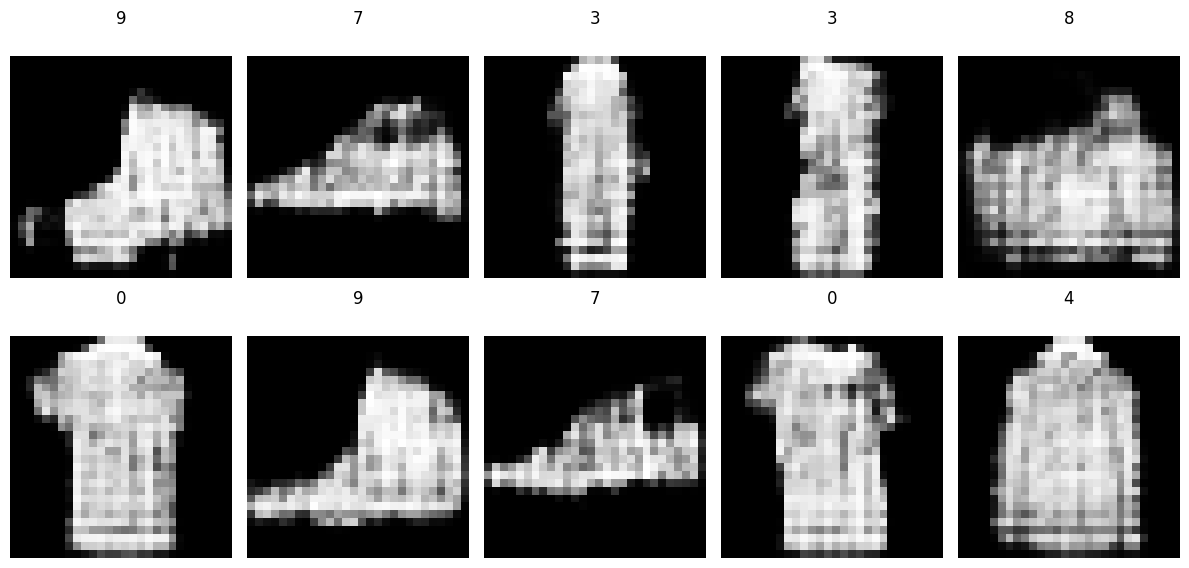

2/2 [==============================] - 0s 4ms/step
Epoch: 4, Batch: 401/468, D_Loss_Real=0.644, D_Loss_Fake=0.611 Gen_Loss=0.769
1/1 [==============================] - 0s 19ms/step


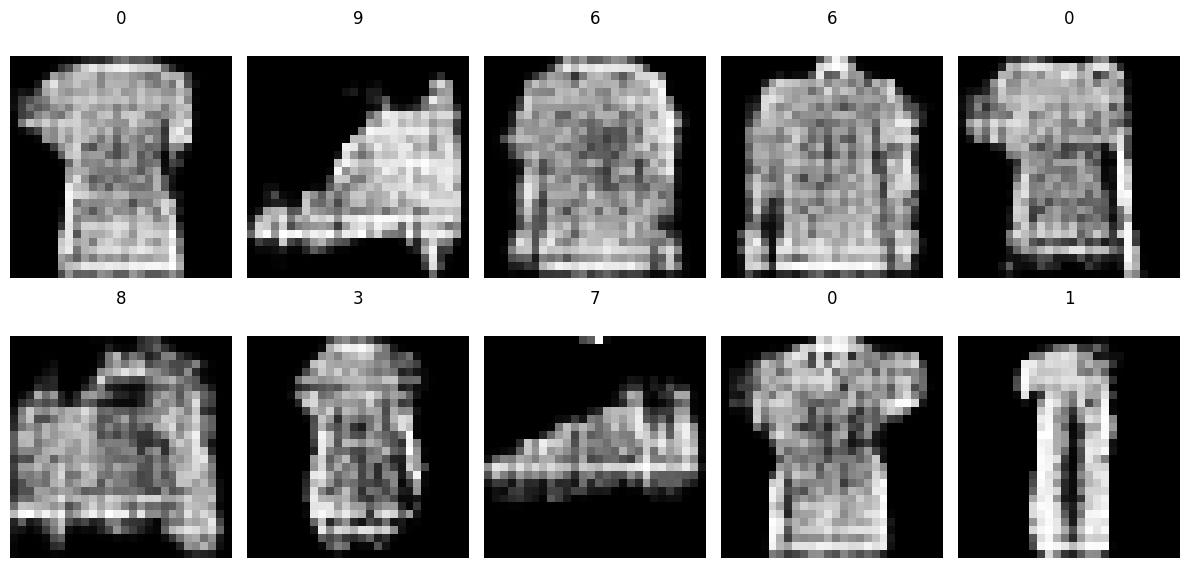

2/2 [==============================] - 0s 4ms/step
Epoch: 5, Batch: 1/468, D_Loss_Real=0.670, D_Loss_Fake=0.653 Gen_Loss=0.785
1/1 [==============================] - 0s 19ms/step


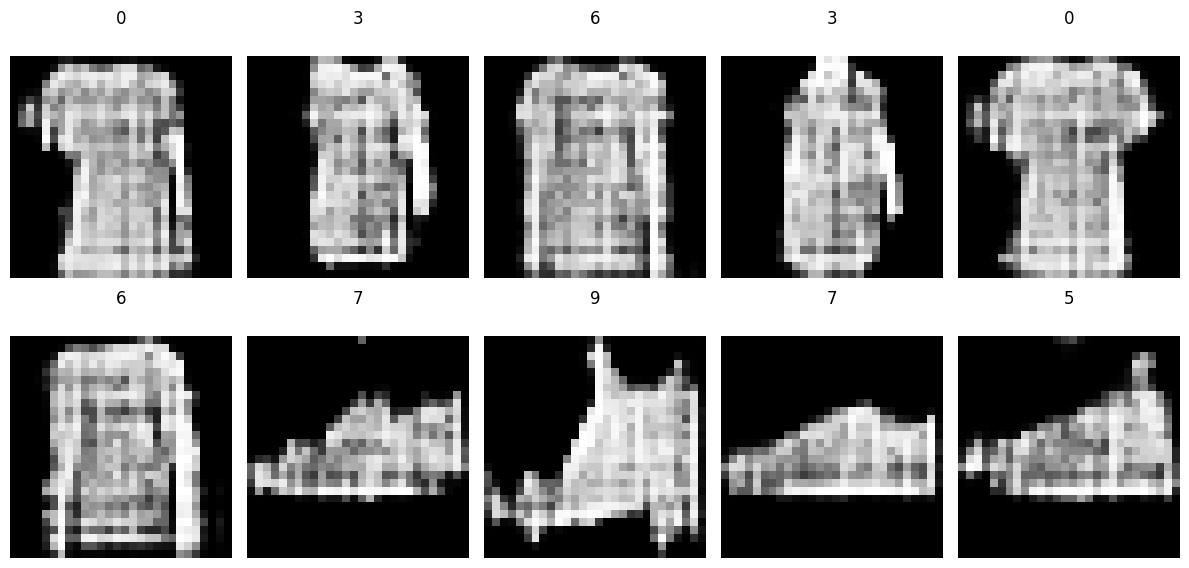

2/2 [==============================] - 0s 5ms/step
Epoch: 5, Batch: 201/468, D_Loss_Real=0.699, D_Loss_Fake=0.654 Gen_Loss=0.793
1/1 [==============================] - 0s 19ms/step


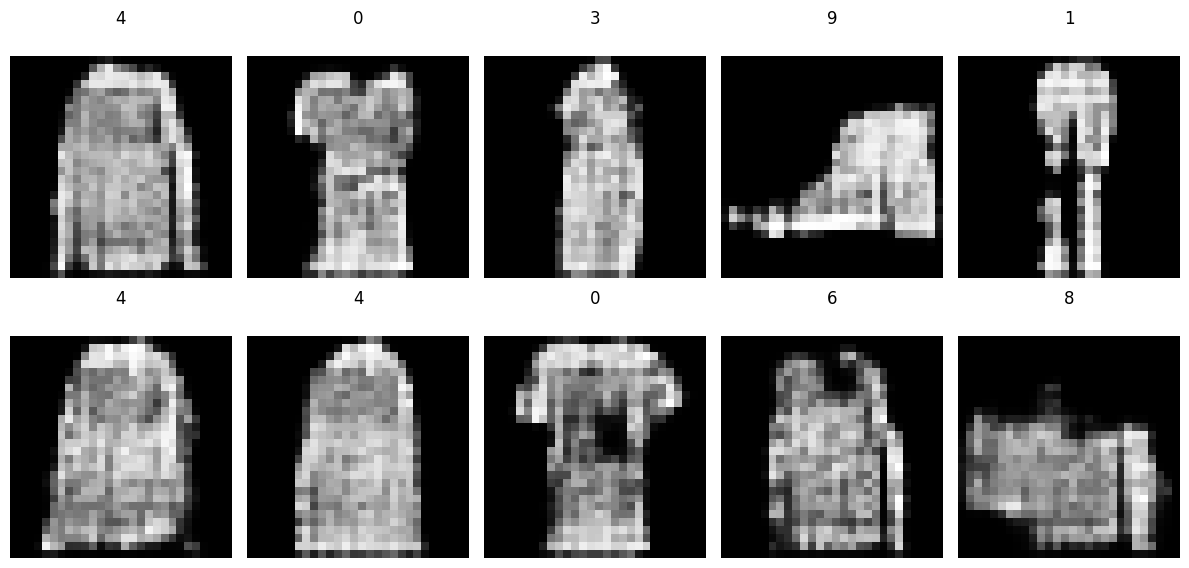

2/2 [==============================] - 0s 4ms/step
Epoch: 5, Batch: 401/468, D_Loss_Real=0.700, D_Loss_Fake=0.665 Gen_Loss=0.797
1/1 [==============================] - 0s 20ms/step


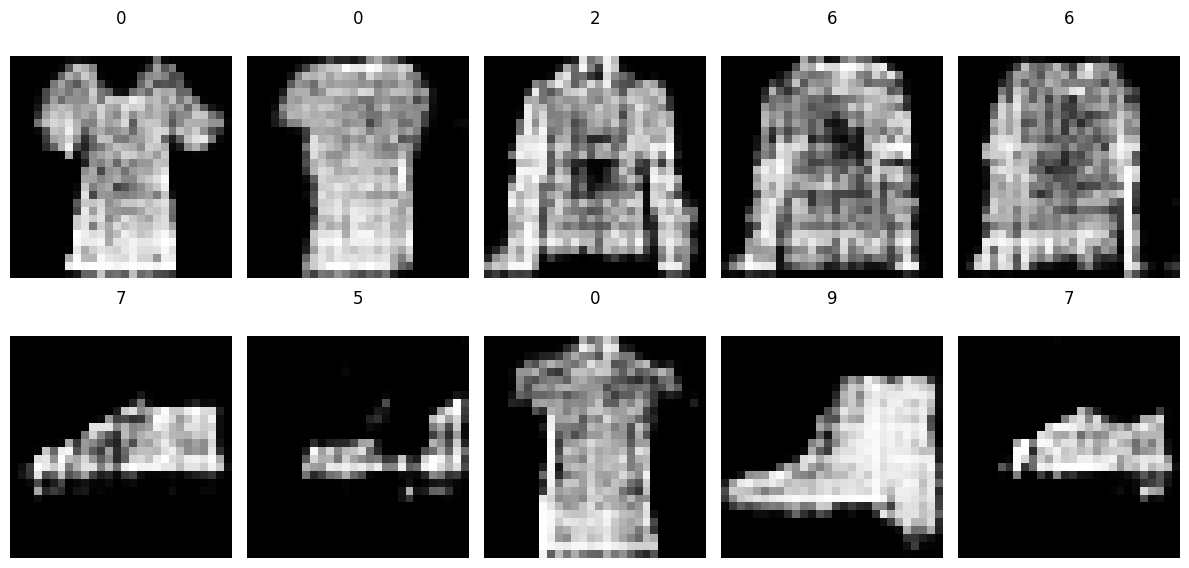

2/2 [==============================] - 0s 4ms/step
Epoch: 6, Batch: 1/468, D_Loss_Real=0.678, D_Loss_Fake=0.684 Gen_Loss=0.732
1/1 [==============================] - 0s 20ms/step


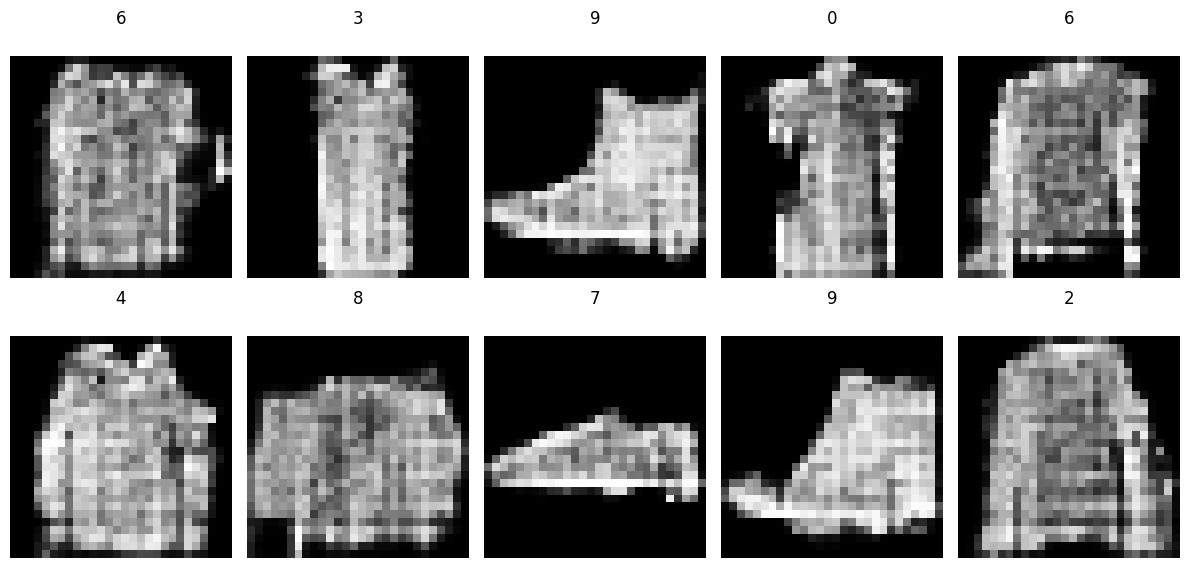

2/2 [==============================] - 0s 4ms/step
Epoch: 6, Batch: 201/468, D_Loss_Real=0.644, D_Loss_Fake=0.668 Gen_Loss=0.759
1/1 [==============================] - 0s 19ms/step


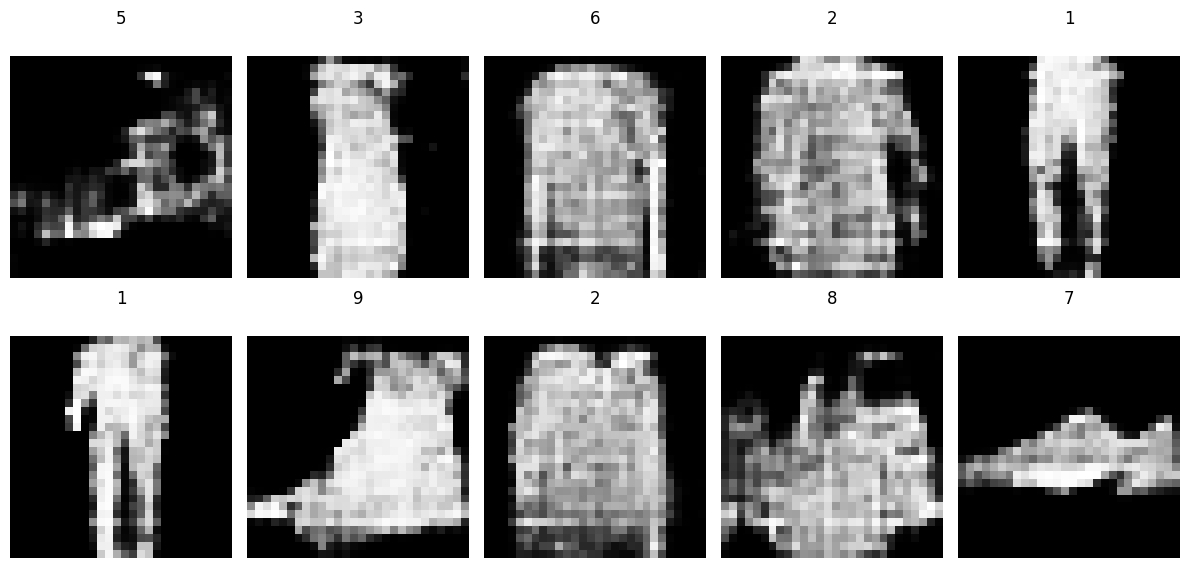

2/2 [==============================] - 0s 5ms/step
Epoch: 6, Batch: 401/468, D_Loss_Real=0.665, D_Loss_Fake=0.661 Gen_Loss=0.760
1/1 [==============================] - 0s 19ms/step


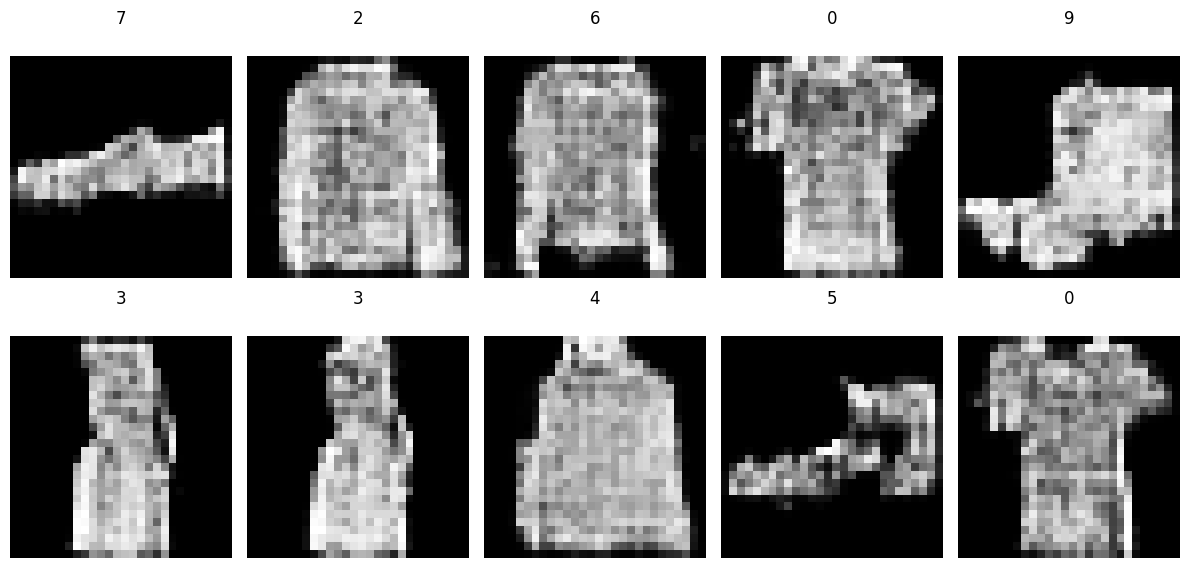

2/2 [==============================] - 0s 4ms/step
Epoch: 7, Batch: 1/468, D_Loss_Real=0.678, D_Loss_Fake=0.606 Gen_Loss=0.857
1/1 [==============================] - 0s 20ms/step


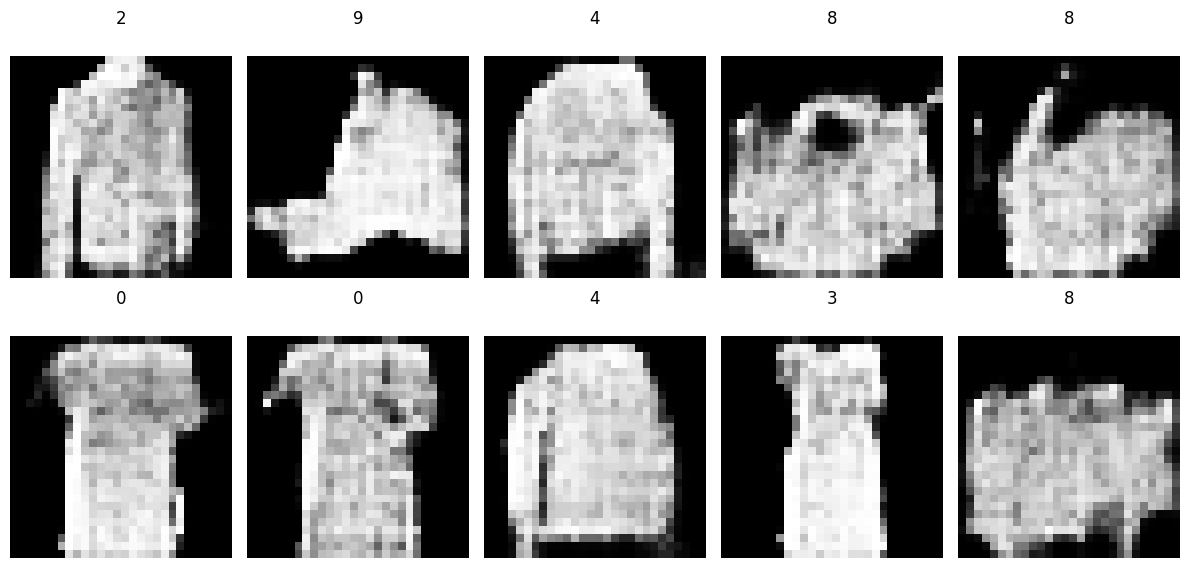

2/2 [==============================] - 0s 4ms/step
Epoch: 7, Batch: 201/468, D_Loss_Real=0.703, D_Loss_Fake=0.673 Gen_Loss=0.769
1/1 [==============================] - 0s 20ms/step


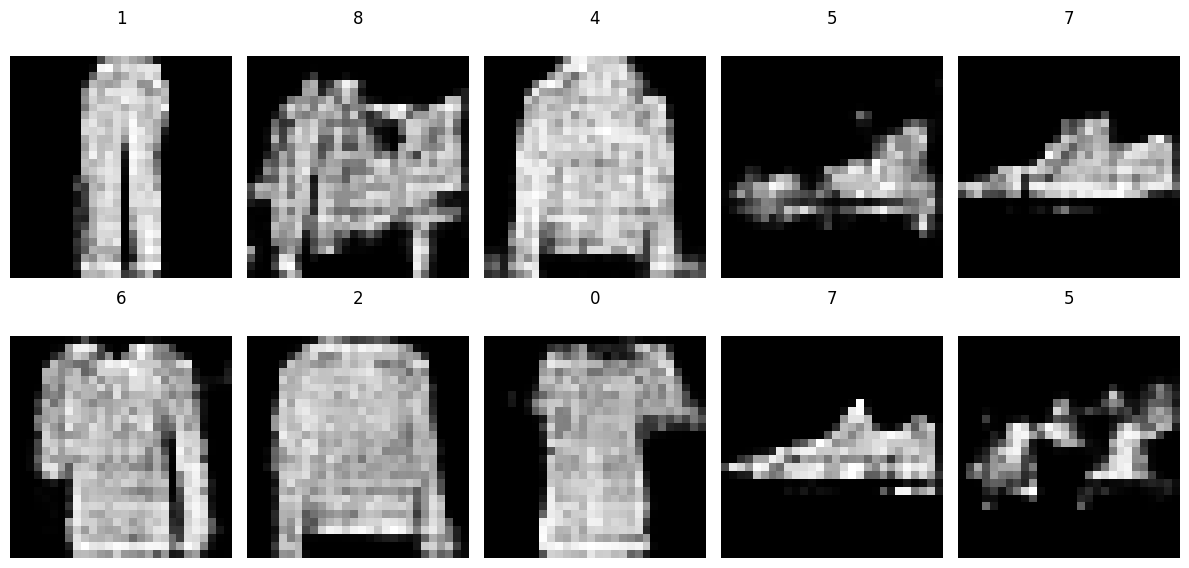

2/2 [==============================] - 0s 4ms/step
Epoch: 7, Batch: 401/468, D_Loss_Real=0.671, D_Loss_Fake=0.684 Gen_Loss=0.753
1/1 [==============================] - 0s 18ms/step


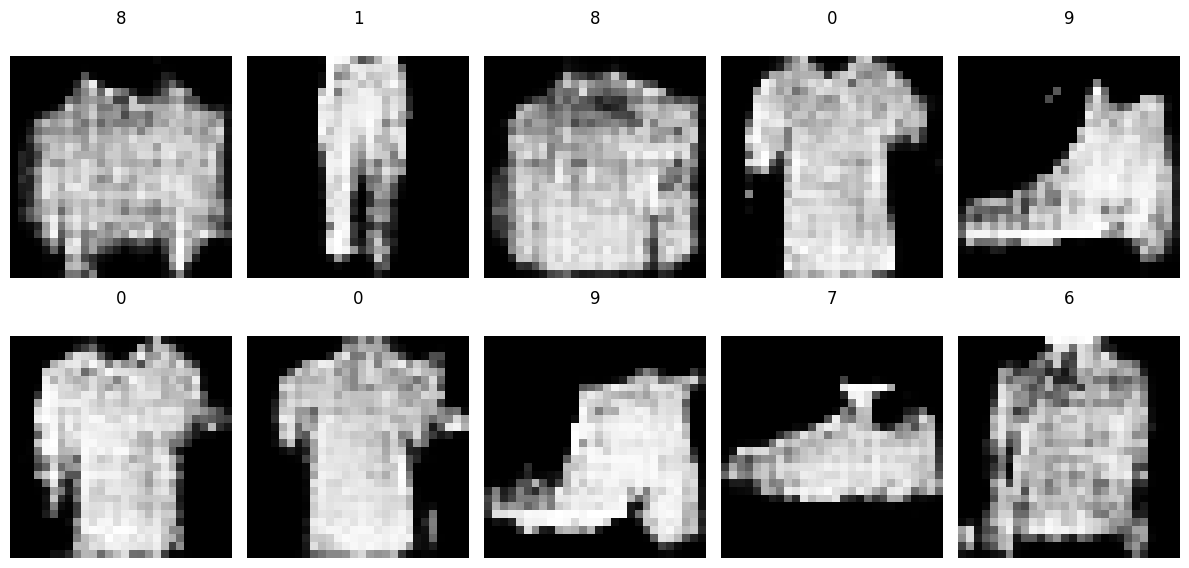

2/2 [==============================] - 0s 4ms/step
Epoch: 8, Batch: 1/468, D_Loss_Real=0.692, D_Loss_Fake=0.636 Gen_Loss=0.787
1/1 [==============================] - 0s 20ms/step


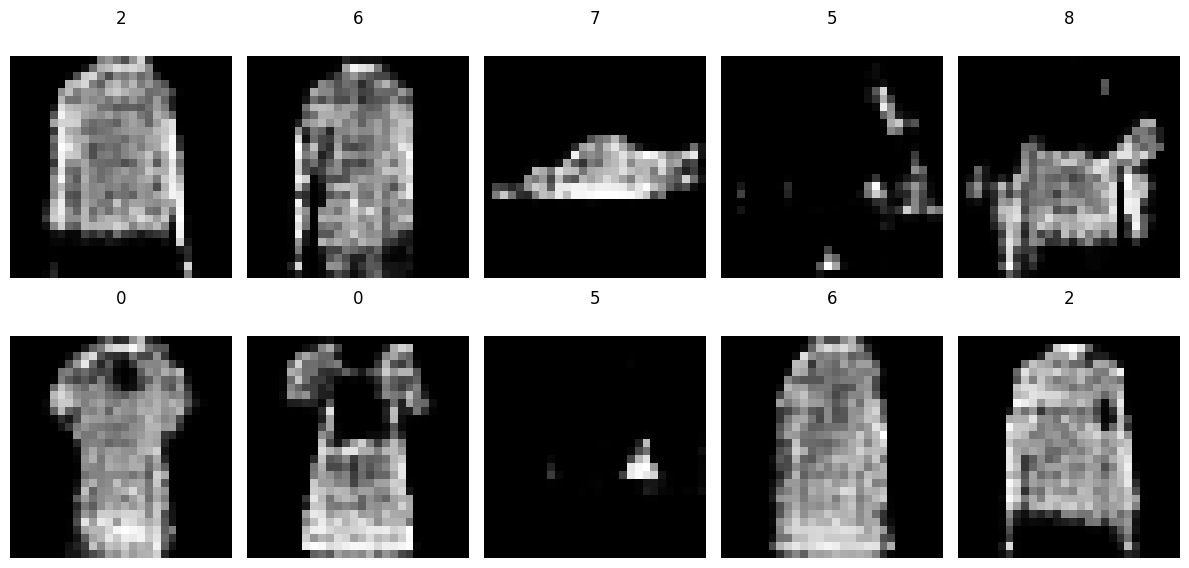

2/2 [==============================] - 0s 5ms/step
Epoch: 8, Batch: 201/468, D_Loss_Real=0.638, D_Loss_Fake=0.672 Gen_Loss=0.776
1/1 [==============================] - 0s 18ms/step


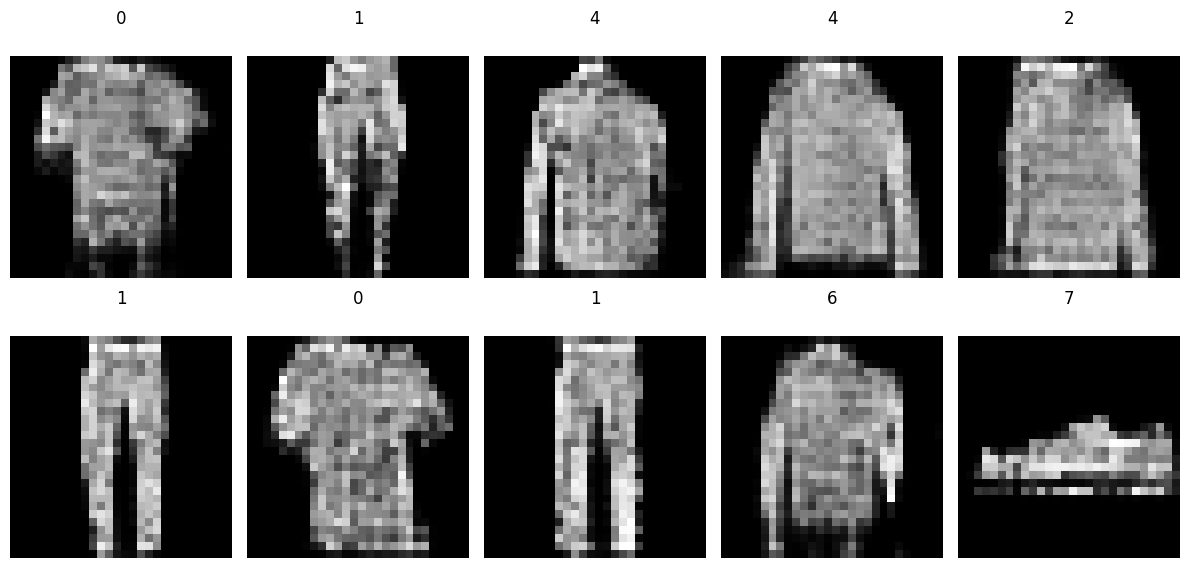

2/2 [==============================] - 0s 4ms/step
Epoch: 8, Batch: 401/468, D_Loss_Real=0.666, D_Loss_Fake=0.674 Gen_Loss=0.748
1/1 [==============================] - 0s 20ms/step


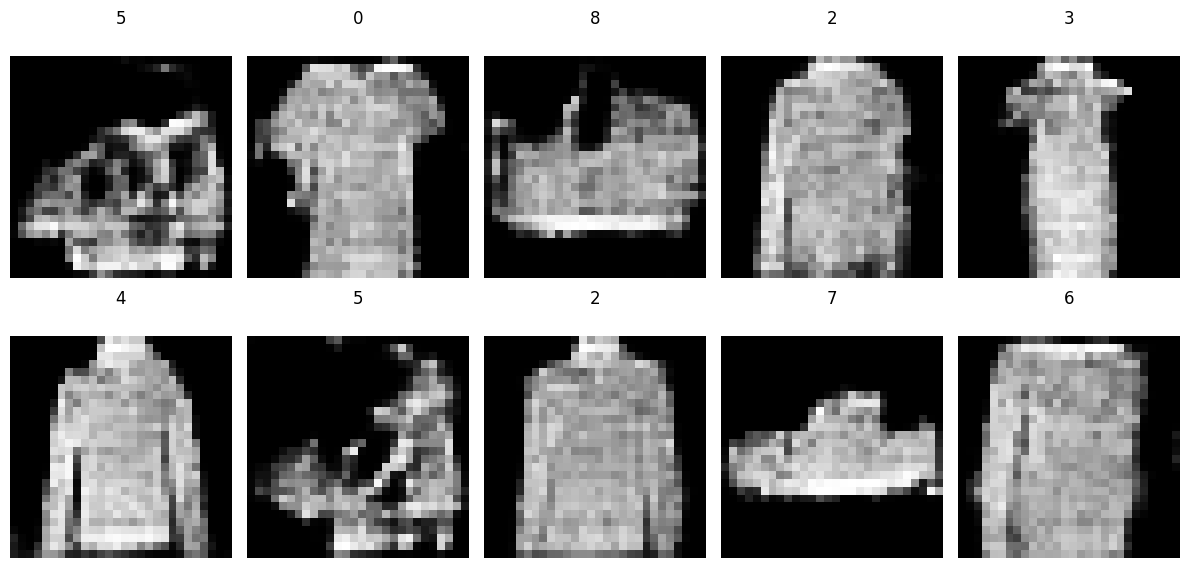

2/2 [==============================] - 0s 4ms/step
Epoch: 9, Batch: 1/468, D_Loss_Real=0.674, D_Loss_Fake=0.674 Gen_Loss=0.758
1/1 [==============================] - 0s 19ms/step


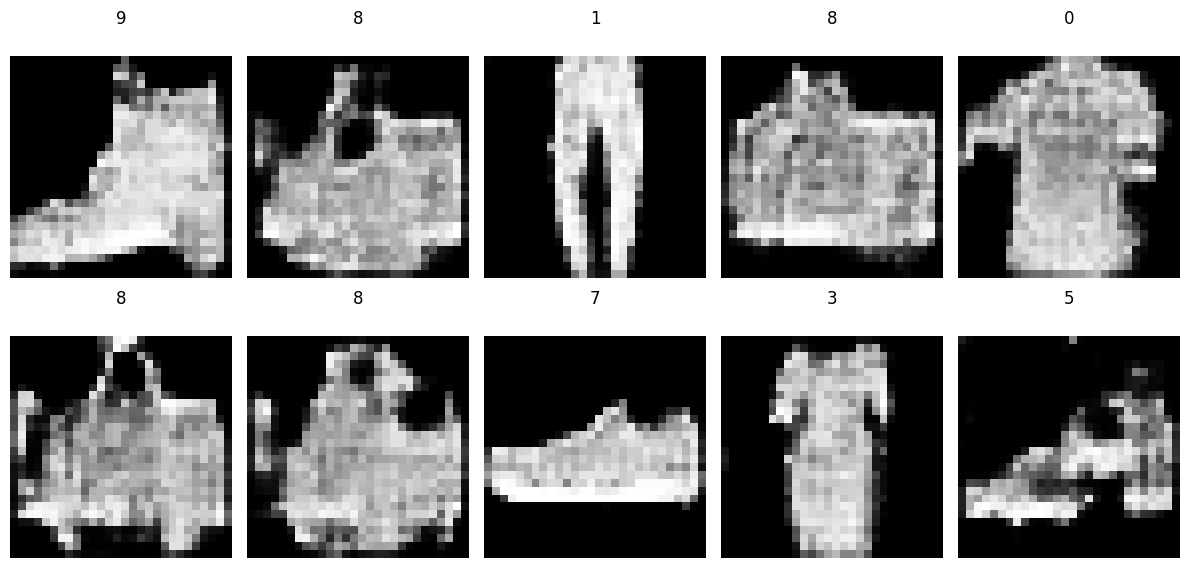

2/2 [==============================] - 0s 4ms/step
Epoch: 9, Batch: 201/468, D_Loss_Real=0.694, D_Loss_Fake=0.557 Gen_Loss=0.938
1/1 [==============================] - 0s 19ms/step


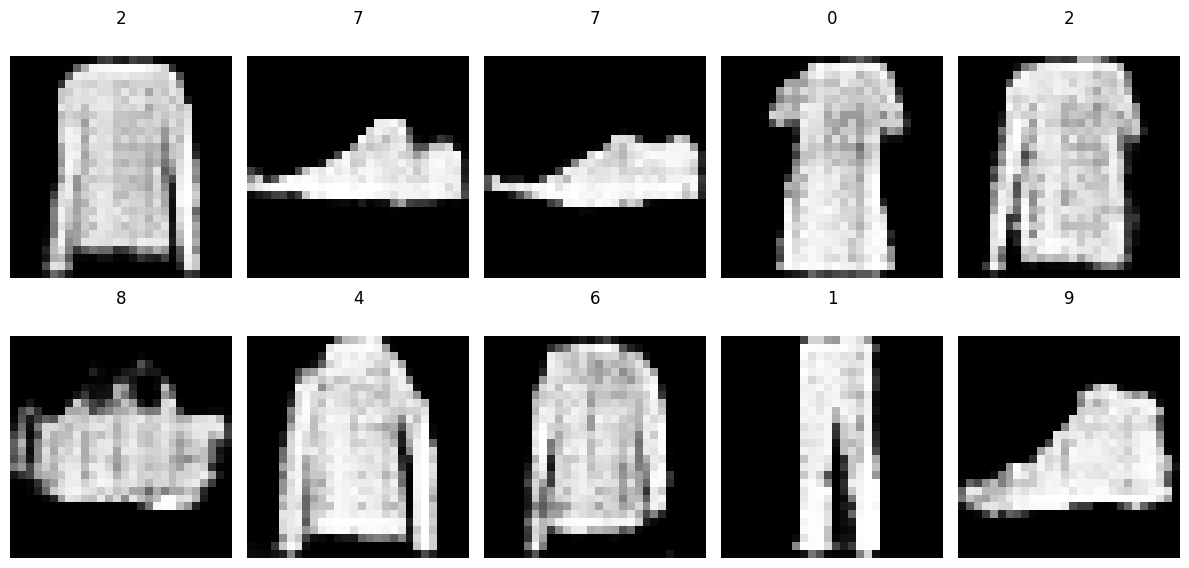

2/2 [==============================] - 0s 4ms/step
Epoch: 9, Batch: 401/468, D_Loss_Real=0.610, D_Loss_Fake=0.652 Gen_Loss=0.794
1/1 [==============================] - 0s 20ms/step


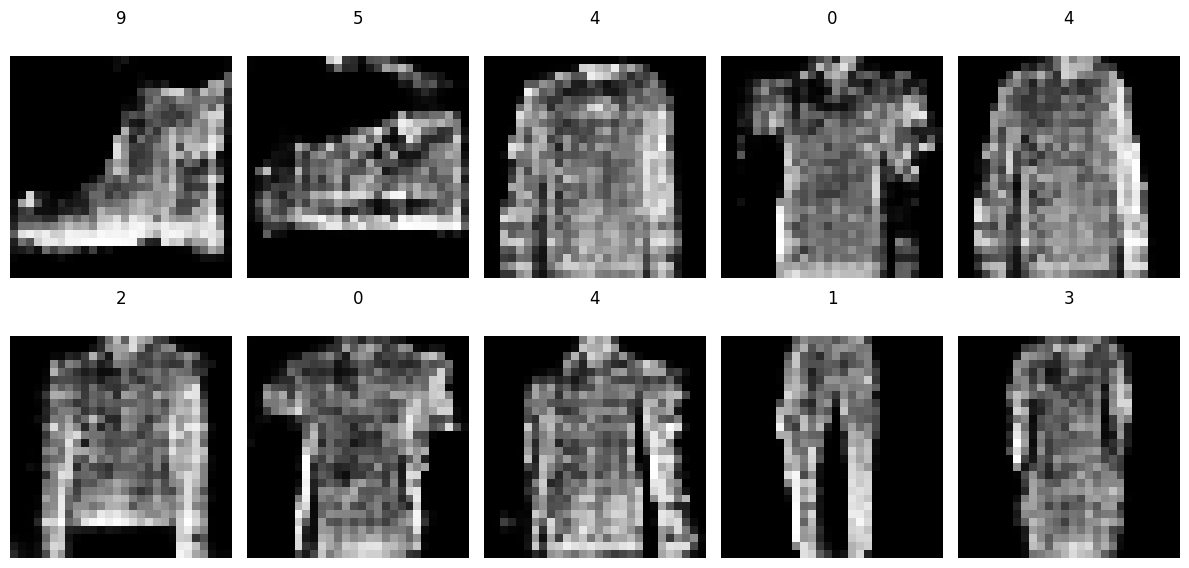

2/2 [==============================] - 0s 4ms/step
Epoch: 10, Batch: 1/468, D_Loss_Real=0.620, D_Loss_Fake=0.675 Gen_Loss=0.784
1/1 [==============================] - 0s 20ms/step


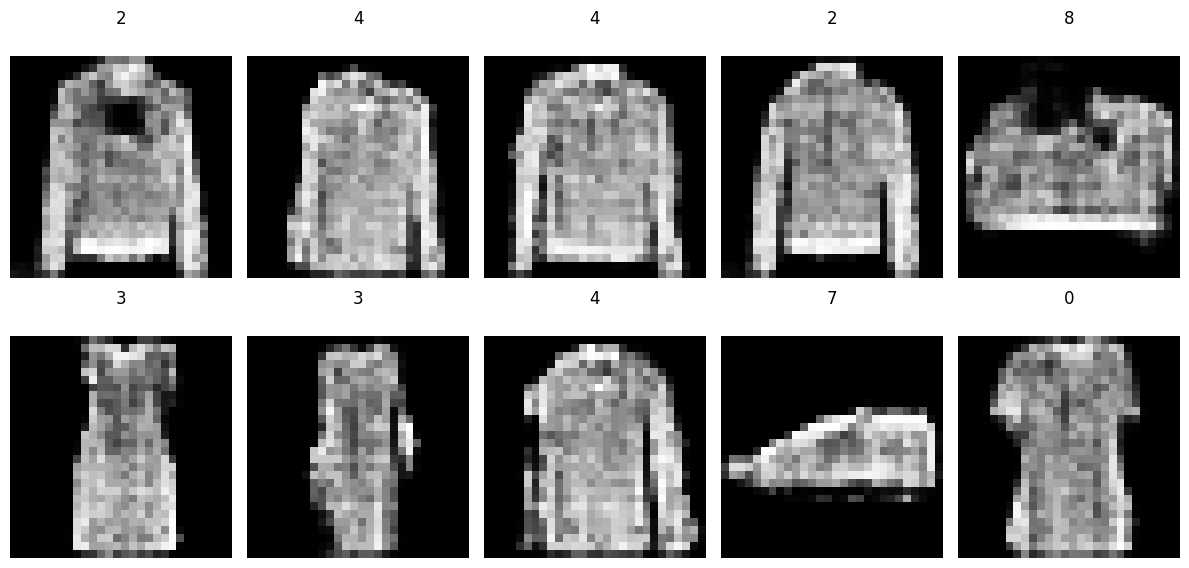

2/2 [==============================] - 0s 5ms/step
Epoch: 10, Batch: 201/468, D_Loss_Real=0.663, D_Loss_Fake=0.676 Gen_Loss=0.772
1/1 [==============================] - 0s 19ms/step


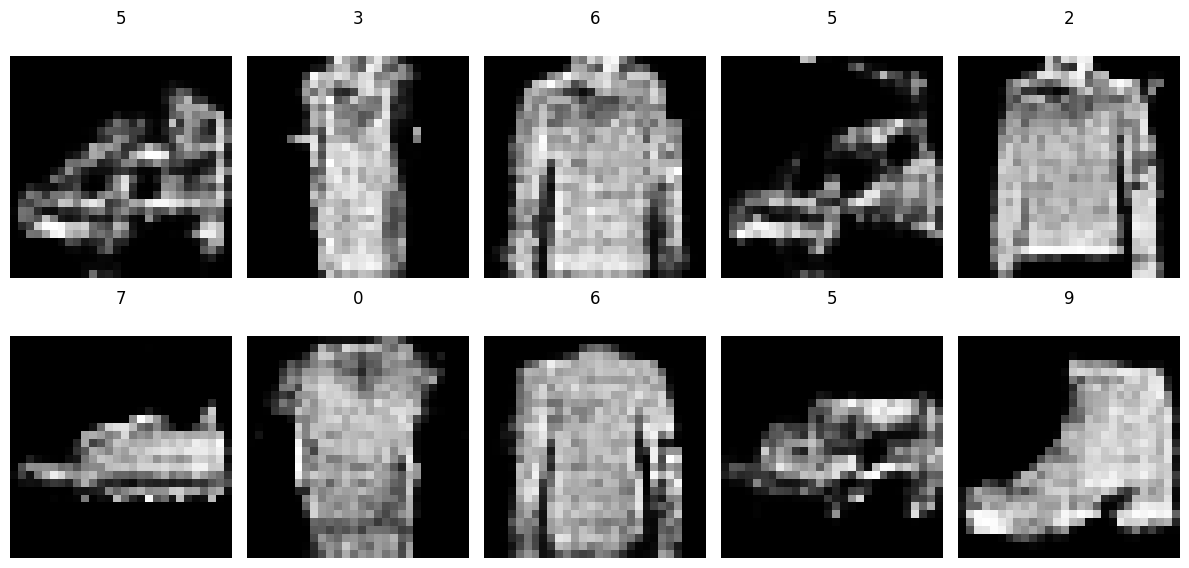

2/2 [==============================] - 0s 3ms/step
Epoch: 10, Batch: 401/468, D_Loss_Real=0.637, D_Loss_Fake=0.642 Gen_Loss=0.754
1/1 [==============================] - 0s 23ms/step


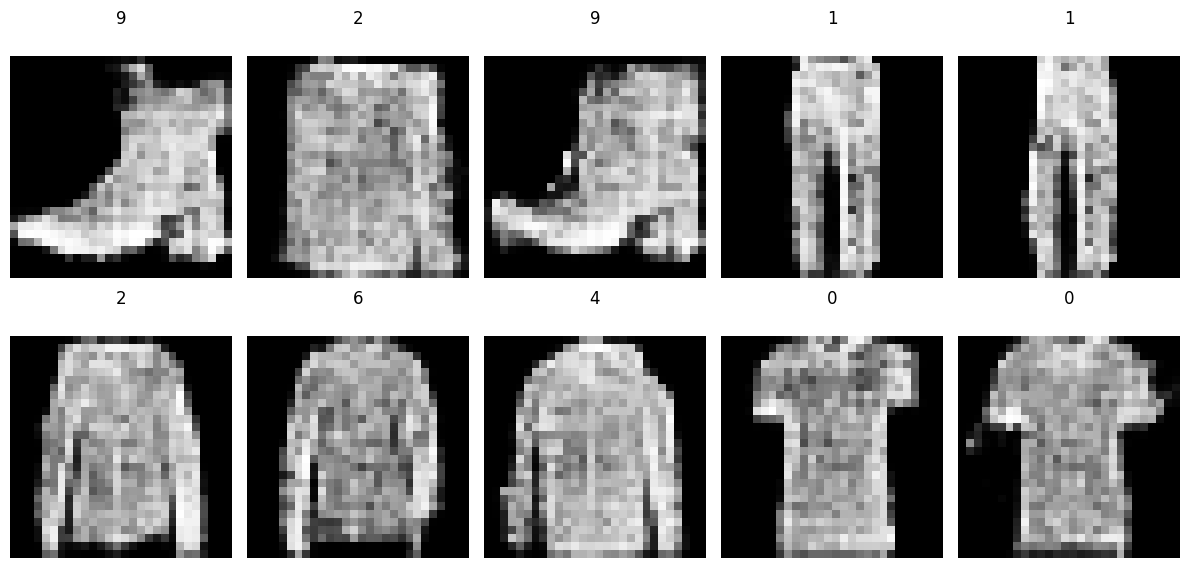

2/2 [==============================] - 0s 4ms/step


In [53]:
train(gen_model, dis_model, gan_model, data, y_train, latent_dim)

In [54]:
gen_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

4/4 [==============================] - 0s 96ms/step


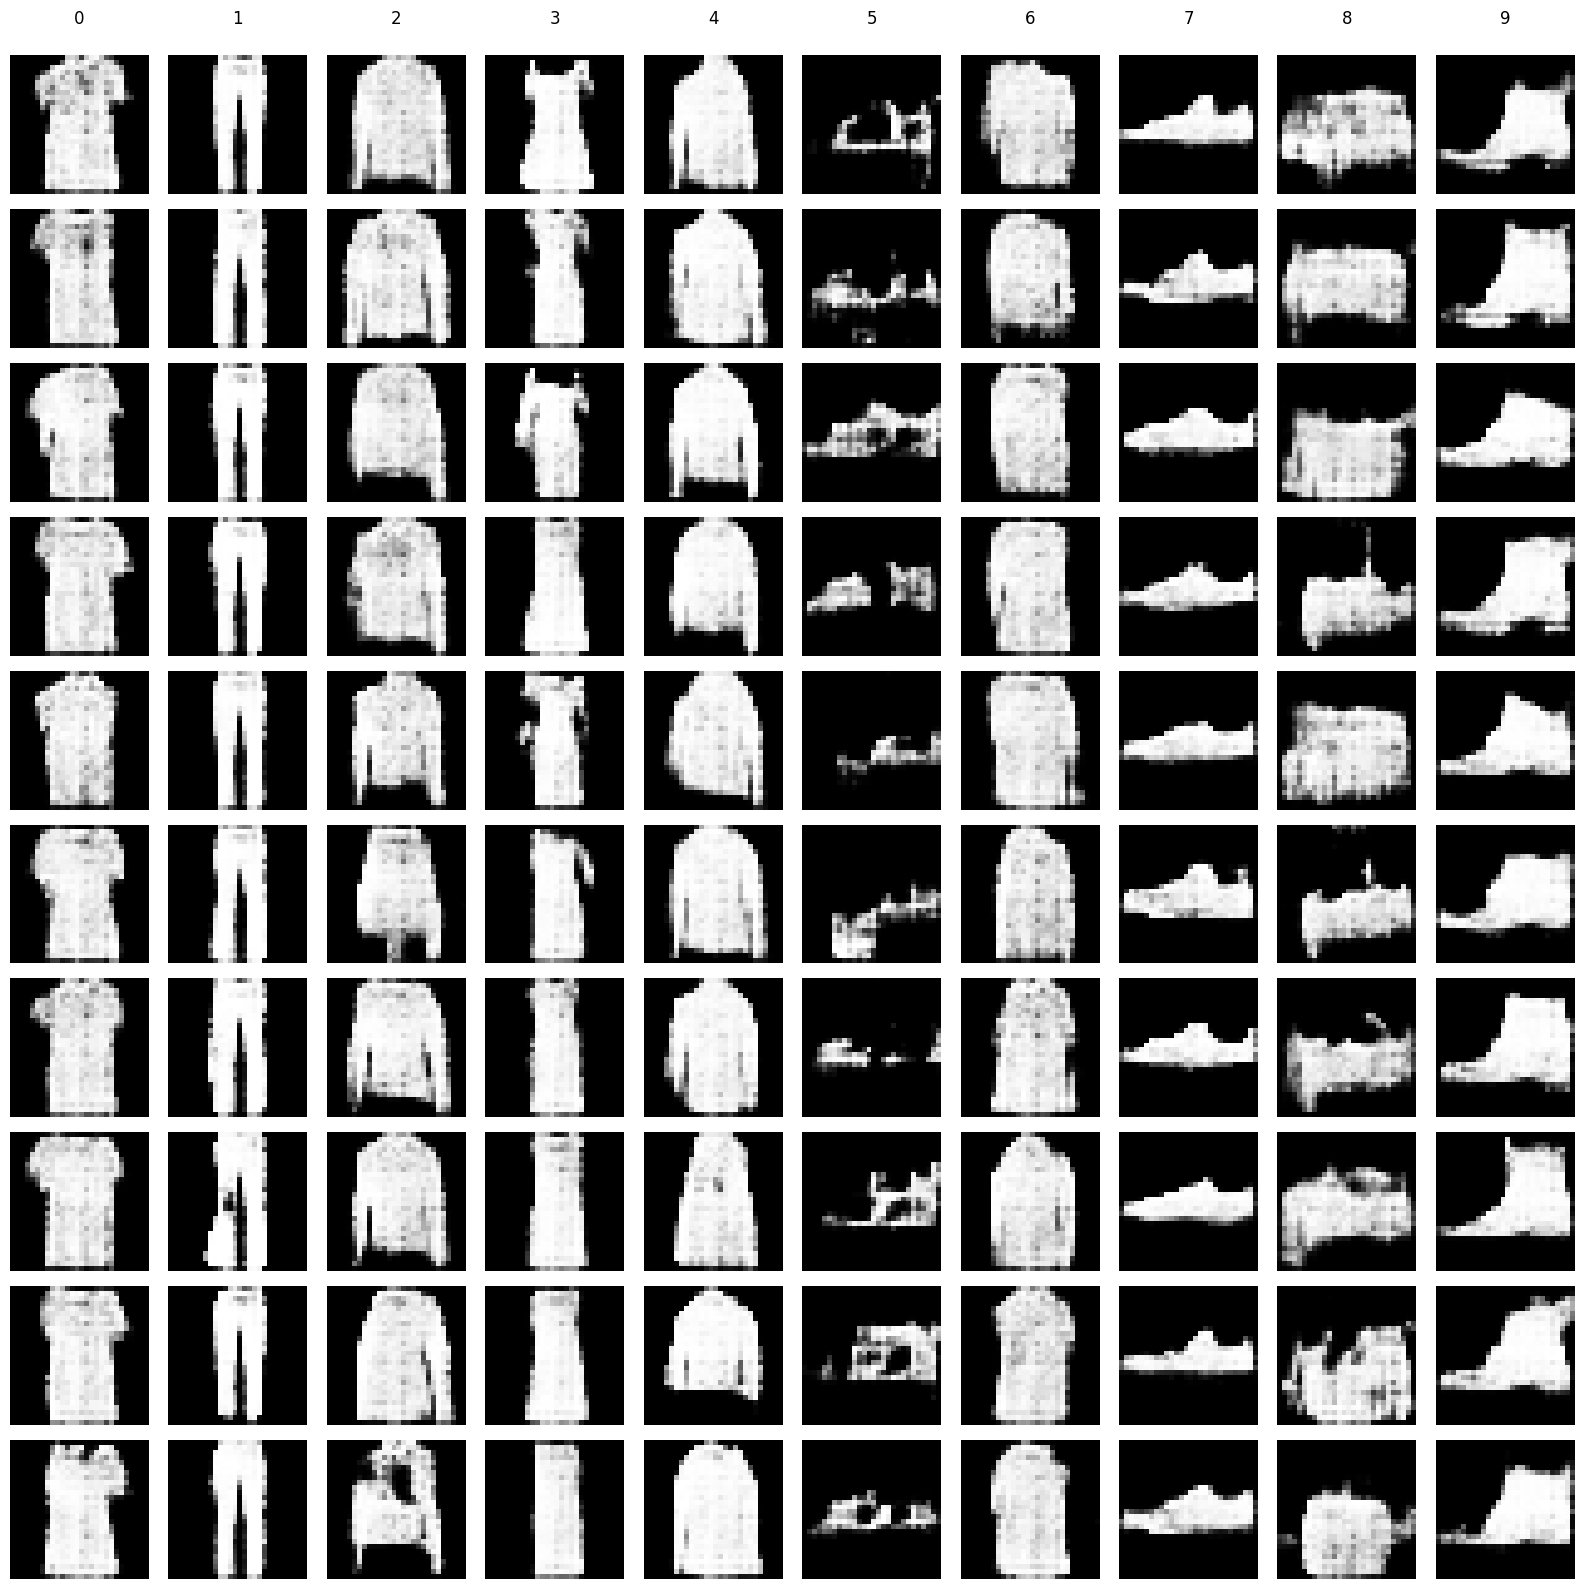

In [55]:
# Generate latent points
latent_points, _ = latent_vector(100, 100)

# Specify labels that we want (0-9 repeated 10 times)
labels = np.asarray([x for _ in range(10) for x in range(10)])

# Load previously saved generator model
model = gen_model

# Generate images
gen_imgs  = model.predict([latent_points, labels])

# Scale from [-1, 1] to [0, 1]
gen_imgs = (gen_imgs + 1) / 2.0

# Display images
fig, axs = plt.subplots(10, 10, sharey=False, tight_layout=True, figsize=(16,16), facecolor='white')
k=0
for i in range(0,10):
    for j in range(0,10):
        axs[i,j].matshow(gen_imgs[k], cmap='gray')
        axs[0,j].set(title=labels[k])
        axs[i,j].axis('off')
        k=k+1
plt.show() 